<a href="https://colab.research.google.com/github/GhazalehKeyvani/Avina/blob/main/MLCrashCourse/fa_Intro_to_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#معرفی شبکه ی عصبی

##اهداف یادگیری



*   ایجاد یک شبکه ی عصبی عمیق ساده

*   هایپر پارامترها را برای یک شبکه عصبی عمیق هماهنگ و تنظیم کنید



## ماژول های مربوطه را وارد کنید

سلول کد مخفی زیر کد لازم را برای اجرای کد در بقیه قسمت های این آزمایشگاه وارد می کند.

In [ ]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import seaborn as sns

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules.")

Imported modules.


##مجموعه داده ها را از اینترنت بارگیری کنید
سلول کد زیر فایل‌های csv. جداگانه را بارگیری می‌کند و دو پاندای DataFrame زیر را ایجاد می‌کند:

*    train_df که شامل مجموعه آموزشی است
*    test_df که شامل مجموعه تست است

In [ ]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")



## نمایش داده ها

سلول کد زیر لایه های پیش پردازشی را ایجاد می کند که خروجی سه ویژگی دارد:

* "طول جغرافیایی" X "طول جغرافیایی" (feature cross)
* «درآمد_متوسط».
* "جمعیت"

این سلول کد ویژگی هایی را که در نهایت به مدل آموزش می دهید و نحوه نمایش هر یک از آن ویژگی ها را مشخص می کند. تبدیل‌ها (جمع‌آوری‌شده در «prepocessing_layers») تا زمانی که یک DataFrame را به آن ارسال نکنید، اعمال نمی‌شوند، که وقتی مدل را آموزش می‌دهیم اتفاق می‌افتد.

ما از «لایه‌های پیش پردازش» هم برای مدل رگرسیون خطی و هم برای مدل شبکه عصبی خود استفاده خواهیم کرد.

(ابزار [`keras.FeatureSpace`](https://keras.io/examples/structured_data/structured_data_classification_with_feature_space) جایگزینی برای ساخت لایه‌های پیش‌پردازش فردی Keras ارائه می‌کند -- اگر احساس ماجراجویی می‌کنید، آن را امتحان کنید!)

In [ ]:
# Keras تنسورهای ورودی مقادیر شناور.
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='longitude'),
    'median_income':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='median_income'),
    'population':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32,
                              name='population')
}

# یک لایه Normalization برای نرمال سازی داده های_درآمد متوسط ایجاد کنید.
median_income = tf.keras.layers.Normalization(
     name='normalization_median_comme',
     axis=None)
median_income.adapt(train_df['median_income'])
median_income = median_income(inputs.get('median_income'))

# یک لایه Normalization برای عادی سازی داده های جمعیت ایجاد کنید.
population = tf.keras.layers.Normalization(
     name='normalization_population',
     axis=None)
population.adapt(train_df['population'])
population = population(inputs.get('population'))

# فهرستی از اعداد که مرزهای سطل را برای عرض جغرافیایی نشان می دهد ایجاد کنید.
# چون ما از یک لایه Normalization، مقادیر برای طول و عرض جغرافیایی استفاده می کنیم
# تقریباً در محدوده 3- تا 3 (نماینده امتیاز Z) خواهد بود.
# ما 20 سطل ایجاد می کنیم که به 21 مرز سطل نیاز دارد (بنابراین، 20+1).
latitude_boundaries = np.linspace(-3, 3, 20+1)

# یک لایه Normalization برای عادی سازی داده های عرض جغرافیایی ایجاد کنید.
latitude = tf.keras.layers.Normalization(
     name='normalization_latitude',
     axis=None)
latitude.adapt(train_df['latitude'])
latitude =latitude(inputs.get('latitude'))

# یک لایه Discretization ایجاد کنید تا داده های عرض جغرافیایی را در سطل ها جدا کنید.
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude')(latitude)

# فهرستی از اعداد که مرزهای سطل را برای طول جغرافیایی نشان می دهند ایجاد کنید.
longitude_boundaries = np.linspace(-3, 3, 20+1)

# یک لایه Normalization برای عادی سازی داده های طول جغرافیایی ایجاد کنید.
longitude = tf.keras.layers.Normalization(
    name='normalization_longitude',
    axis=None)
longitude.adapt(train_df['longitude'])
longitude = longitude(inputs.get('longitude'))

# یک لایه Discretization ایجاد کنید تا داده های طول جغرافیایی را در سطل ها جدا کنید.
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude')(longitude)

# ویژگی های طول و عرض جغرافیایی را در یک بردار تک داغ رد کنید.
feature_cross = tf.keras.layers.HashedCrossing(
     # num_bins قابل تنظیم است: مقادیر بالاتر دقت را بهبود می بخشد، مقادیر کمتر
     # بهبود کارایی.
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude')([latitude, longitude])

# ورودی های ما را به یک تنسور منفرد متصل کنید.
preprocessing_layers = tf.keras.layers.Concatenate()(
    [feature_cross, median_income, population])

print ("لایه های پیش پردازش تعریف شده است.")

لایه های پیش پردازش تعریف شده است.


## یک مدل رگرسیون خطی به عنوان خط پایه بسازید

قبل از ایجاد یک شبکه عصبی عمیق، با اجرای یک مدل رگرسیون خطی ساده که از لایه‌های پیش پردازشی که ایجاد کرده‌اید استفاده می‌کند، یک فقدان [baseline](https://developers.google.com/machine-learning/glossary/#baseline) پیدا کنید.

In [ ]:
#@title Define the plotting function.

def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first.
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function.")

Defined the plot_the_loss_curve function.


In [ ]:
#@title Define functions to create and train a linear regression model
def create_model(my_inputs, my_outputs, my_learning_rate):
  """Create and compile a simple linear regression model."""
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(
      learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()])

  return model


def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """Feed a dataset into the model in order to train it."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_median_house_value_normalized(
      np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions.")

Defined the create_model and train_model functions.


In [ ]:
#@title Define normalized label columns
# Create Normalization layers to normalize the median_house_value data.
# Because median_house_value is our label (i.e., the target value we're
# predicting), these layers won't be added to our model.
train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(
    np.array(train_df['median_house_value']))

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(
    np.array(test_df['median_house_value']))


In [ ]:
#@title Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer.
  dense_output = tf.keras.layers.Dense(units=1,
                              name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor.
  outputs = {
    'dense_output': dense_output
  }
  return outputs

سلول کد زیر را برای فراخوانی توابع تعریف شده در دو سلول کد قبلی اجرا کنید. (پیام های هشدار را نادیده بگیرید.)


**توجه:**

 از آنجایی که ما تمام داده های ورودی، **از جمله برچسب** را مقیاس بندی کرده ایم، مقادیر تلفات به دست آمده *بسیار کمتر* از مدل های Colab های قبلی خواهد بود (به عنوان مثال، [Representation with a Feature Cross]( https://colab.sandbox.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/representation_with_a_feature_cross.ipynb)).


**توجه:**

بسته به نسخه TensorFlow، اجرای این سلول ممکن است پیام های هشدار ایجاد کند. لطفا این هشدارها را نادیده بگیرید.

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'households'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/14 [==============================] - 2s 47ms/step - loss: 0.8545 - mean_squared_error: 0.8545 - val_loss: 0.7057 - val_mean_squared_error: 0.7057
Epoch 2/15
14/14 [==============================] - 0s 9ms/step - loss: 0.6186 - mean_squared_error: 0.6186 - val_loss: 0.5260 - val_mean_squared_error: 0.5260
Epoch 3/15
14/14 [==============================] - 0s 8ms/step - loss: 0.4749 - mean_squared_error: 0.4749 - val_loss: 0.4246 - val_mean_squared_error: 0.4246
Epoch 4/15
14/14 [==============================] - 0s 9ms/step - loss: 0.3992 - mean_squared_error: 0.3992 - val_loss: 0.3752 - val_mean_squared_error: 0.3752
Epoch 5/15
14/14 [==============================] - 0s 10ms/step - loss: 0.3629 - mean_squared_error: 0.3629 - val_loss: 0.3542 - val_mean_squared_error: 0.3542
Epoch 6/15
14/14 [==============================] - 0s 14ms/step - loss: 0.3486 - mean_squared_error: 0.3486 - val_loss: 0.3460 - val_mean_squared_error: 0.3460
Epoch 7/15
14/14 [==============================

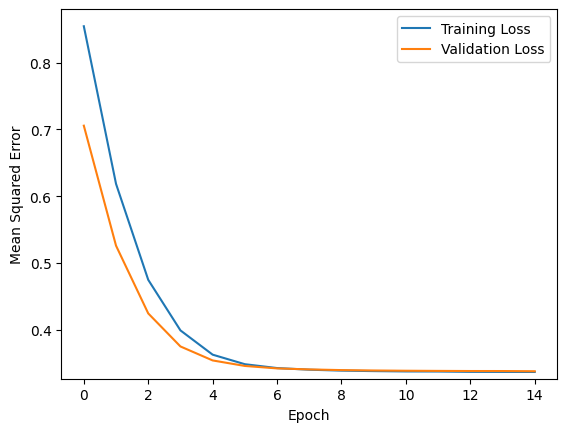


 مدل رگرسیون خطی را در برابر مجموعه آزمایشی ارزیابی کنید:
3/3 [==============================] - 0s 14ms/step - loss: 0.3602 - mean_squared_error: 0.3602


{'loss': 0.3602418601512909, 'mean_squared_error': 0.3602418601512909}

In [ ]:
# متغیرهای زیر هایپرپارامترها هستند.
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# مجموعه آموزشی اصلی را به یک مجموعه آموزشی کاهش یافته و یک
# مجموعه اعتبارسنجی.
validation_split = 0.2

outputs = get_outputs_linear_regression()

# توپوگرافی مدل را تعیین کنید.
my_model = create_model(inputs, outputs, learning_rate)

# مدل را روی مجموعه آموزشی نرمال شده آموزش دهید.
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size,
                           label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])


test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name)) # برچسب را جدا کنید
print("\n مدل رگرسیون خطی را در برابر مجموعه آزمایشی ارزیابی کنید:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

## یک مدل شبکه عصبی عمیق را تعریف کنید

تابع "get_outputs_dnn" توپوگرافی شبکه عصبی عمیق (DNN) را تعریف می کند و موارد زیر را مشخص می کند:

* تعداد [لایه ها](https://developers.google.com/machine-learning/glossary/#layer) در شبکه عصبی عمیق.
* تعداد [node](https://developers.google.com/machine-learning/glossary/#node) در هر لایه.

تابع «get_outputs_dnn» همچنین [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) هر لایه را تعریف می‌کند.

اولین لایه «Dense» «لایه‌های پیش‌پردازش» تعریف‌شده قبلی را به عنوان ورودی می‌گیرد.

In [ ]:
def get_outputs_dnn():
   # یک لایه متراکم با 20 گره ایجاد کنید.
   dense_output = tf.keras.layers.Dense(units=20,
                              activation='relu',
                              name='hidden_dense_layer_1')(preprocessing_layers)
   # یک لایه متراکم با 12 گره ایجاد کنید.
   dense_output = tf.keras.layers.Dense(units=12,
                              activation='relu',
                              name='hidden_dense_layer_2')(dense_output)
   # لایه خروجی متراکم را ایجاد کنید.
   dense_output = tf.keras.layers.Dense(units=1,
                               name='dense_output')(dense_output)

   # دیکشنری خروجی تعریف کنید که برای سازنده مدل ارسال می کنیم.
   outputs = {
     'dense_output': dense_output
   }

   return outputs

## توابع را برای ساختن و آموزش شبکه عصبی عمیق فراخوانی کنید

بسیار خوب، زمان آن فرا رسیده است که شبکه عصبی عمیق را آموزش دهیم. اگر زمان اجازه می‌دهد، با سه هایپرپارامتر آزمایش کنید تا ببینید آیا می‌توانید تلفات را کاهش دهید
در مقابل مجموعه تست

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'households'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/14 [==============================] - 3s 29ms/step - loss: 0.5027 - mean_squared_error: 0.5027 - val_loss: 0.3538 - val_mean_squared_error: 0.3538
Epoch 2/20
14/14 [==============================] - 0s 13ms/step - loss: 0.3471 - mean_squared_error: 0.3471 - val_loss: 0.3357 - val_mean_squared_error: 0.3357
Epoch 3/20
14/14 [==============================] - 0s 13ms/step - loss: 0.3302 - mean_squared_error: 0.3302 - val_loss: 0.3324 - val_mean_squared_error: 0.3324
Epoch 4/20
14/14 [==============================] - 0s 13ms/step - loss: 0.3262 - mean_squared_error: 0.3262 - val_loss: 0.3274 - val_mean_squared_error: 0.3274
Epoch 5/20
14/14 [==============================] - 0s 13ms/step - loss: 0.3249 - mean_squared_error: 0.3249 - val_loss: 0.3258 - val_mean_squared_error: 0.3258
Epoch 6/20
14/14 [==============================] - 0s 13ms/step - loss: 0.3225 - mean_squared_error: 0.3225 - val_loss: 0.3253 - val_mean_squared_error: 0.3253
Epoch 7/20
14/14 [===========================

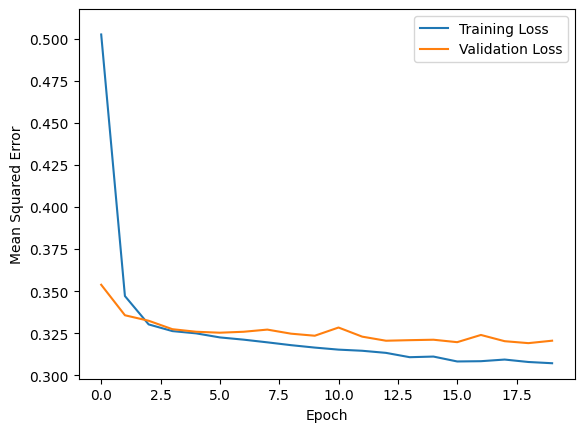


 Evaluate the new model against the test set:
3/3 [==============================] - 0s 14ms/step - loss: 0.3439 - mean_squared_error: 0.3439


{'loss': 0.34387898445129395, 'mean_squared_error': 0.34387898445129395}

In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Split the original training set into a reduced training set and a
# validation set.
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography.
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate)

# Train the model on the normalized training set. We're passing the entire
# normalized training set, but the model will only use the features
# defined in our inputs.
epochs, mse, history = train_model(my_model, train_df, epochs,
                                   batch_size, label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(np.array(test_features.pop(label_name))) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size, return_dict=True)

##تمرین 1: دو مدل را با هم مقایسه کنید

In [ ]:
#@title برای مشاهده پاسخ احتمالی دوبار کلیک کنید

# با فرض همگرا شدن مدل خطی و
# مدل شبکه عصبی عمیق نیز همگرا شد، لطفا
# loss مجموعه تست را برای هر کدام مقایسه کنید.
# در آزمایشات ما، از دست دادن عصبی عمیق
# مدل شبکه به طور مداوم کمتر از
# مدل رگرسیون خطی که
# نشان می دهد که مدل شبکه عصبی عمیق
# پیش بینی های بهتر از
#  مدل رگرسیون خطی است.

##تمرین 2:تپولوژی شبکه عصبی عمیق را بهینه کنید

In [ ]:
#@title برای مشاهده پاسخ احتمالی دوبار کلیک کنید

# پاسخ های زیادی ممکن است. متوجه شدیم
# روند زیر:
# * دو لایه از یک لایه بهتر عمل کردند، اما
# سه لایه عملکرد قابل توجهی نداشتند
# بهتر از دو لایه.
# به عبارت دیگر، دو لایه بهترین به نظر می رسید.
# * تنظیم توپوگرافی به شرح زیر تولید شده است
# نتایج نسبتاً خوب با نتایج نسبتاً کمی
# گره:
# * 10 گره در لایه اول.
# * 6 گره در لایه دوم.
# با کاهش تعداد گره ها در هر لایه
# کمتر از قبل، ضرر تست افزایش یافته است.
# با این حال، بسته به برنامه شما، سخت افزار
# محدودیت و درد نسبی ایجاد شده
# با یک مدل کمتر دقیق، یک شبکه کوچکتر
# (مثلاً 6 گره در لایه اول و
#گره 4 در لایه دوم) ممکن است باشد
#قابل قبول